# Segmentation of Road from Satellite imagery

## Importing Libraries

In [0]:
import warnings
warnings.filterwarnings('ignore')

import os
import cv2
#from google.colab.patches import cv2_imshow
import numpy as np
import tensorflow as tf
import pandas as pd
from keras.models import Model, load_model
from skimage.morphology import label
import pickle
from keras import backend as K

from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import random
from skimage.io import imread, imshow, imread_collection, concatenate_images
from matplotlib import pyplot as plt
import h5py

seed = 56

In [6]:
!pip install tensorflow==1.14.0

     |████████████████████████████████| 109.2MB 38kB/s 
     |████████████████████████████████| 3.2MB 44.6MB/s 
     |████████████████████████████████| 491kB 39.1MB/s 
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorflow 2.2.0rc2
    Uninstalling tensorflow-2.2.0rc2:
      Successfully uninstalled tensorflow-2.2.0rc2


In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
base_path = "gdrive/My\ Drive/MapSegClean/"
%cd gdrive/My\ Drive/MapSegClean/

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/My Drive/MapSegClean


## Defining Custom Loss functions and accuracy Metric.

In [2]:
#Source: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  
  return iou

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [0]:
def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

## Defining Our Model

In [0]:
from keras.models import Model, load_model
import tensorflow as tf
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import optimizers
from keras.layers import BatchNormalization
import keras

In [0]:
inputs = Input((256, 256, 3))
s = Lambda(lambda x: x / 255) (inputs)

conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
conv1 = BatchNormalization() (conv1)
conv1 = Dropout(0.1) (conv1)
conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1)
conv1 = BatchNormalization() (conv1)
pooling1 = MaxPooling2D((2, 2)) (conv1)

conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling1)
conv2 = BatchNormalization() (conv2)
conv2 = Dropout(0.1) (conv2)
conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2)
conv2 = BatchNormalization() (conv2)
pooling2 = MaxPooling2D((2, 2)) (conv2)

conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling2)
conv3 = BatchNormalization() (conv3)
conv3 = Dropout(0.2) (conv3)
conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3)
conv3 = BatchNormalization() (conv3)
pooling3 = MaxPooling2D((2, 2)) (conv3)

conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling3)
conv4 = BatchNormalization() (conv4)
conv4 = Dropout(0.2) (conv4)
conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4)
conv4 = BatchNormalization() (conv4)
pooling4 = MaxPooling2D(pool_size=(2, 2)) (conv4)

conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling4)
conv5 = BatchNormalization() (conv5)
conv5 = Dropout(0.3) (conv5)
conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5)
conv5 = BatchNormalization() (conv5)


upsample6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv5)
upsample6 = concatenate([upsample6, conv4])
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample6)
conv6 = BatchNormalization() (conv6)
conv6 = Dropout(0.2) (conv6)
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv6)
conv6 = BatchNormalization() (conv6)

upsample7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv6)
upsample7 = concatenate([upsample7, conv3])
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample7)
conv7 = BatchNormalization() (conv7)
conv7 = Dropout(0.2) (conv7)
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv7)
conv7 = BatchNormalization() (conv7)

upsample8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv7)
upsample8 = concatenate([upsample8, conv2])
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample8)
conv8 = BatchNormalization() (conv8)
conv8 = Dropout(0.1) (conv8)
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv8)
conv8 = BatchNormalization() (conv8)

upsample9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv8)
upsample9 = concatenate([upsample9, conv1], axis=3)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample9)
conv9 = BatchNormalization() (conv9)
conv9 = Dropout(0.1) (conv9)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv9)
conv9 = BatchNormalization() (conv9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 16) 0         

### HYPER_PARAMETERS

In [0]:
LEARNING_RATE = 0.0001

### Initializing Callbacks

In [0]:
#from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime

In [0]:
model_path = "/content/gdrive/My Drive/ISPRS/Models/cars.h5"
checkpointer = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystopper = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4)

### Compiling the model

In [0]:
opt = keras.optimizers.adam(LEARNING_RATE)
model.compile(
      optimizer=opt,
      loss=soft_dice_loss,
      metrics=[iou_coef])

In [0]:
import keras.losses, keras.metrics
keras.losses.soft_dice_loss = soft_dice_loss
keras.metrics.iou_coef = iou_coef

In [5]:
from keras.models import load_model
model = load_model('/content/gdrive/My Drive/MapSegClean/Models/model.h5',
                   custom_objects={'loss': soft_dice_loss})







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




## Testing our Model

### On Test Images

In [0]:
model.load_weights("/content/gdrive/My Drive/ISPRS/Models/Final_unet_cars.h5")

In [7]:
"""Test"""
import cv2
import glob
import numpy as np
import h5py

#test_images = np.array([cv2.imread(file) for file in glob.glob("/home/bisag/Desktop/Road-Segmentation/I/")])
#test_masks = np.array([cv2.imread(file) for file in glob.glob("/home/bisag/Desktop/Road-Segmentation/M/")])

test_images = []
files = glob.glob ("/content/gdrive/My Drive/ISPRS/Test/*.png")
for myFile in files:
    print(myFile)
    image = cv2.imread (myFile)
    test_images.append (image)


    
#test_images = cv2.imread("/home/bisag/Desktop/Road-Segmentation/I/1.png")
#test_masks = cv2.imread("/home/bisag/Desktop/Road-Segmentation/M/1.png")

test_images = np.array(test_images)

print(test_images.shape)



/content/gdrive/My Drive/ISPRS/Test/top_potsdam_2_10_RGB_2.png
/content/gdrive/My Drive/ISPRS/Test/top_potsdam_2_10_RGB_3.png
/content/gdrive/My Drive/ISPRS/Test/top_potsdam_2_10_RGB_23.png
/content/gdrive/My Drive/ISPRS/Test/top_potsdam_2_10_RGB_4.png
/content/gdrive/My Drive/ISPRS/Test/top_potsdam_2_10_RGB_27.png
/content/gdrive/My Drive/ISPRS/Test/top_potsdam_2_10_RGB_102.png
/content/gdrive/My Drive/ISPRS/Test/top_potsdam_2_10_RGB_91.png
/content/gdrive/My Drive/ISPRS/Test/top_potsdam_2_10_RGB_70.png
/content/gdrive/My Drive/ISPRS/Test/top_potsdam_2_10_RGB_115.png
/content/gdrive/My Drive/ISPRS/Test/top_potsdam_2_10_RGB_130.png
/content/gdrive/My Drive/ISPRS/Test/top_potsdam_2_10_RGB_156.png
/content/gdrive/My Drive/ISPRS/Test/top_potsdam_2_10_RGB_228.png
/content/gdrive/My Drive/ISPRS/Test/top_potsdam_2_10_RGB_259.png
/content/gdrive/My Drive/ISPRS/Test/top_potsdam_2_10_RGB_266.png
/content/gdrive/My Drive/ISPRS/Test/top_potsdam_2_10_RGB_316.png
/content/gdrive/My Drive/ISPRS/Test

In [10]:
predictions = model.predict(test_images, verbose=1)*255

40/40 [==============================] - 6s 144ms/step


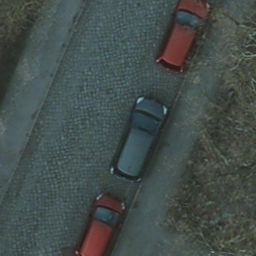

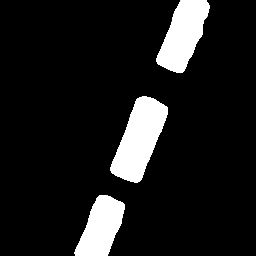

In [11]:
from google.colab.patches import cv2_imshow
cv2_imshow(np.squeeze(test_images[0]))
cv2_imshow(np.squeeze(predictions[0]))

In [0]:
thresh_val = 0.1
predicton_threshold = (predictions > thresh_val).astype(np.uint8)

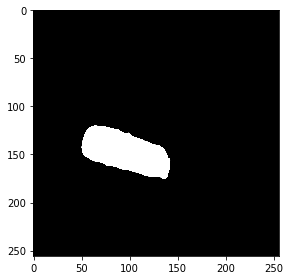

In [0]:
import matplotlib

for i in range(len(predictions)):
    cv2.imwrite( "/content/gdrive/My Drive/ISPRS/Results/" + str(i) + "Image.png"  , np.squeeze(test_images[i][:,:,0]))
    #cv2.imwrite( "/home/bisag/Desktop/Road-Segmentation/Results/" + str(i) + "Prediction.png"  , np.squeeze(predictions[i][:,:,0]))
    #cv2.imwrite( "/home/bisag/Desktop/Road-Segmentation/Results/" + str(i) + "Prediction_Threshold.png"  , np.squeeze(predicton_threshold[i][:,:,0]))
    #matplotlib.image.imsave('/home/bisag/Desktop/Road-Segmentation/Results/000.png', np.squeeze(predicton_threshold[0][:,:,0]))
    matplotlib.image.imsave("/content/gdrive/My Drive/ISPRS/Results/" + str(i) + "Prediction.png"  , np.squeeze(predictions[i][:,:,0]))
    matplotlib.image.imsave( "/content/gdrive/My Drive/ISPRS/Results/" + str(i) + "Prediction_Threshold.png"  , np.squeeze(predicton_threshold[i][:,:,0]))

    #imshow(np.squeeze(predictions[0][:,:,0]))

imshow(np.squeeze(predictions[0][:,:,0]))

#import scipy.misc
#scipy.misc.imsave('/home/bisag/Desktop/Road-Segmentation/Results/00.png', np.squeeze(predictions[0][:,:,0]))